1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

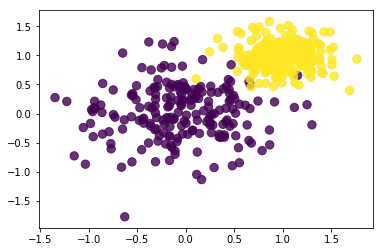

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

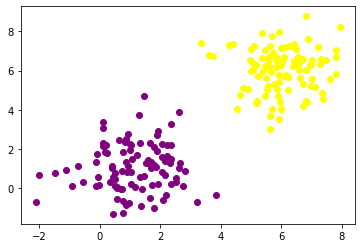

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import scipy 

def generate_value(mean,std):
    return np.random.normal(mean, std, 2)

mean = 6
std = 1
N = 100

cat_1 = []
for i in range(N):
    cat_1.append(generate_value(mean,std))
    
mean = 1
std = 1.2

cat_2 = []
for i in range(N):
    cat_2.append(generate_value(mean,std))
    
for pt in cat_1:
    plt.plot(pt[0],pt[1],'o', color='yellow')
    
for pt in cat_2:
    plt.plot(pt[0],pt[1],'o', color='purple')
plt.show()


2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


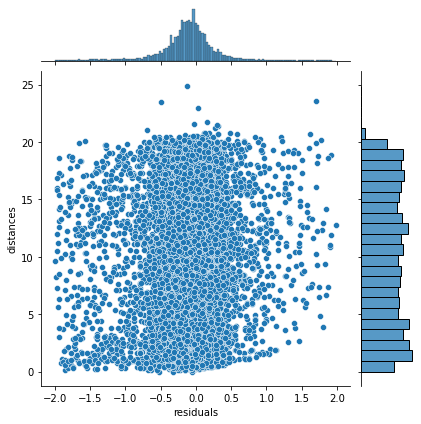

In [3]:
#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
file = open("data/residuals_261.pkl", "rb")
data = pickle.load(file)
df = pd.DataFrame(data.tolist())
df = df[abs(df['residuals'])<2]
display(df)
sns.jointplot(data=df, x="residuals", y="distances")

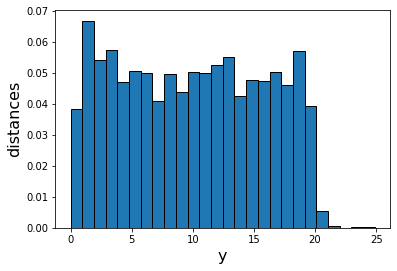

In [4]:
bin_value = ( df['distances'].max() - df['distances'].min() )/(2*scipy.stats.iqr(df['distances'].values)/(pow(len(df.index),1./3)))

n,bins,patches = plt.hist(df['distances'].values, density=True, bins=int(bin_value),edgecolor = "black")
plt.xlabel("y", fontsize=16)  
plt.ylabel("distances", fontsize=16)
plt.show()

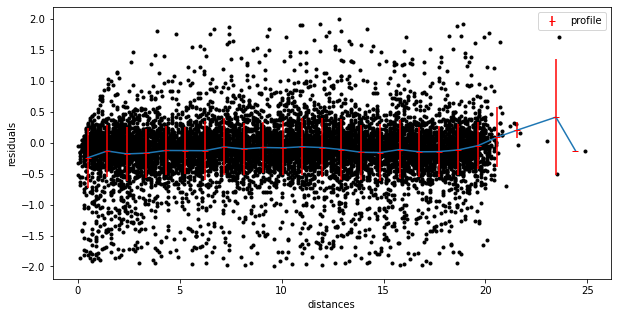

In [5]:
x = []
y = []
err_y = []
for i in range(1,len(bins)):
    res_in_bin = np.array(df[(df['distances']>bins[i-1]) & (df['distances']<=bins[i])]['residuals'].values)
    if(len(res_in_bin) > 0):
        x.append((bins[i]+bins[i-1])/2)
        y.append(np.mean(res_in_bin))
        err_y.append(np.std(res_in_bin))
        
plt.subplots(figsize=(10,5))
plt.scatter(df['distances'], df['residuals'], marker='.', c='black')
plt.errorbar(x, y, err_y,fmt='_', ecolor='r', color='r', label='profile')
plt.xlabel('distances')
plt.ylabel('residuals')
plt.legend()
plt.plot(x,y)
plt.show()

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


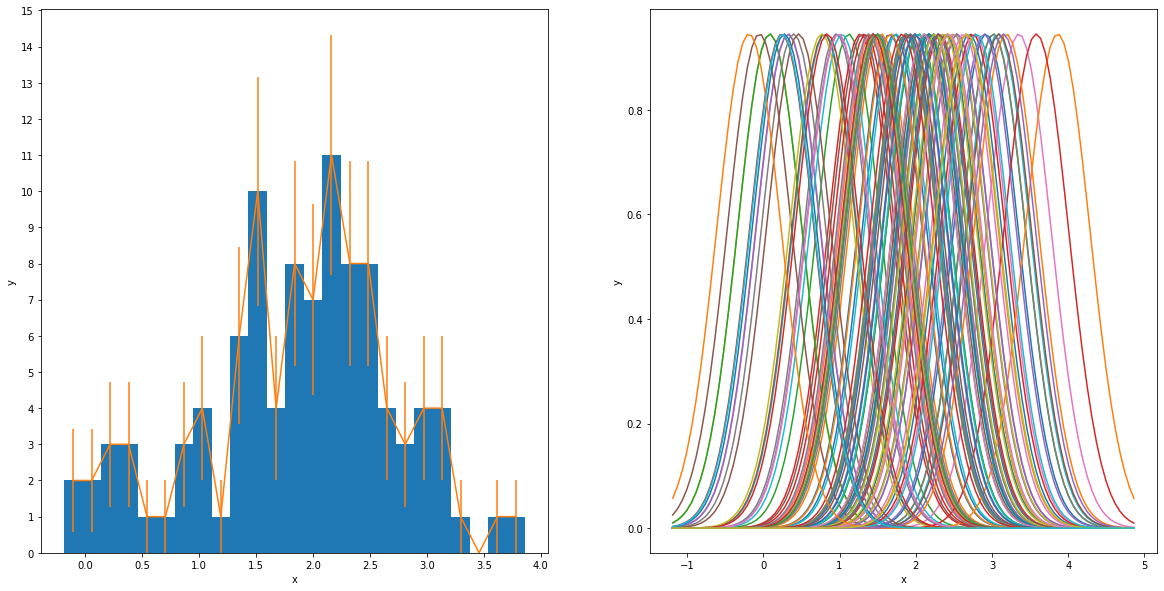

In [8]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import norm, poisson
from scipy import integrate

mean = 2

std = 1

size = 100

bins = 25

x = np.random.normal(loc=mean, scale=std, size=(size,))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10)) 
h, bins, _ = axs[0].hist(x, bins=bins)

axs[0].set_ylabel("y")
axs[0].set_xlabel('x')
axs[0].yaxis.set_major_locator(MultipleLocator(1))

bin_centres = (bins[:-1] + bins[1:])/2.

err = np.sqrt(h)
axs[0].errorbar(bin_centres, h, yerr=err)

axs[1].set_ylabel('y')
axs[1].set_xlabel('x')
lin_s = np.linspace(x.min()-1, x.max()+1, num=100)

summed_pdf = np.zeros(lin_s.shape)
std_x = 1.06 * std*(size**(-1/5)) 

for elem in x:
    axs[1].plot(lin_s, norm.pdf(lin_s, loc=elem, scale=std_x)) 
    summed_pdf = summed_pdf + norm.pdf(lin_s, loc=elem, scale=std_x)

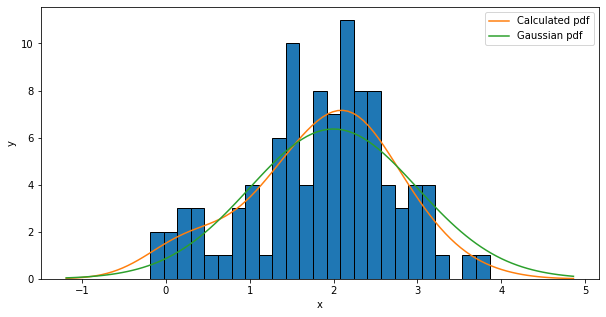

In [9]:
plt.subplots(figsize=(10,5))

h_area = integrate.trapz(h, bin_centres) 
final_area = integrate.trapz(summed_pdf, lin_s)
summed_pdf = summed_pdf / final_area * h_area 

final_area = integrate.trapz(h, bin_centres)
plt.xlabel('x')
plt.ylabel('y')
plt.hist(x, bins=bins, density=False,edgecolor = "black")
plt.plot(lin_s, summed_pdf , label = "Calculated pdf")
plt.plot(lin_s, norm.pdf(lin_s, loc=mean, scale=std) * h_area, label = "Gaussian pdf")
plt.legend()